In [1]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from matplotlib import gridspec

from copy import copy
from matplotlib.colors import LogNorm


### Load Processed Data

In [2]:
jet_pT    = np.load('jet_pT.npy')
cuts      = np.load('cuts.npy')
q_perp    = np.load('q_perp.npy')
asymm_phi = np.load('asymm_angle.npy')
weights   = np.load('weights.npy')

### Apply Cuts

In [3]:
if (len(q_perp) == len(cuts)):
    jet_pT    = jet_pT[cuts]
    q_perp    = q_perp[cuts]
    asymm_phi = asymm_phi[cuts]
    weights   = weights[cuts]
    print("%i / %i Events Remain"%(len(q_perp),len(cuts)))

else:
    print("Cuts already applied!")
    

7234716 / 57882501 Events Remain


In [4]:
unfold = False
if not(unfold):
    print("Weights set to 1.0")
    weights = np.ones(len(weights))

Weights set to 1.0


___

### 2D Asymmetry Histograms

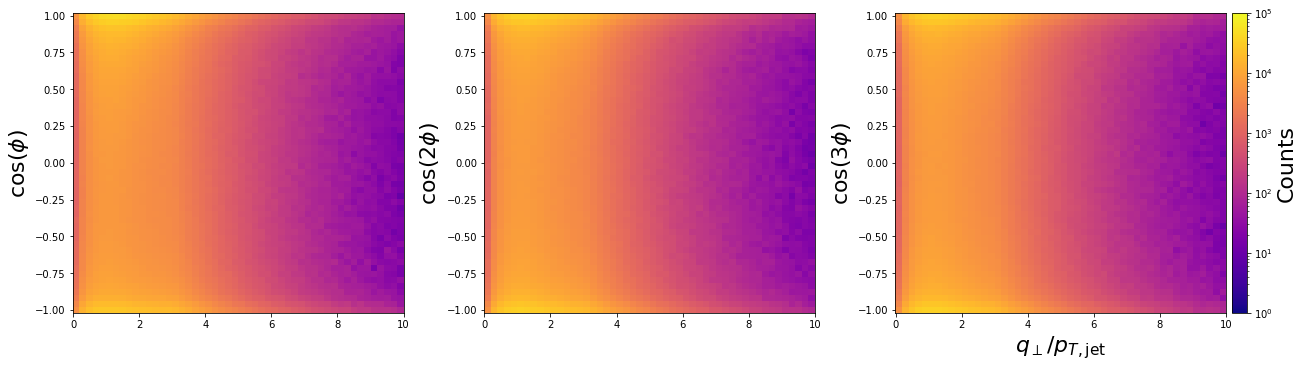

In [24]:
N_Bins = 51
xbins = np.linspace(-0.01,10.01,N_Bins)
ybins = np.linspace(-1.02,1.02,N_Bins)
cmap = copy(plt.cm.plasma)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), constrained_layout=True)

h1, xedges1, yedges1 = np.histogram2d(q_perp, np.cos(asymm_phi),bins=(xbins,ybins), weights=weights)
h2, xedges2, yedges2 = np.histogram2d(q_perp, np.cos(2*asymm_phi), bins=(xbins,ybins), weights=weights)
h3, xedges3, yedges3 = np.histogram2d(q_perp, np.cos(3*asymm_phi), bins=(xbins,ybins), weights=weights)

pcm = axes[0].pcolormesh(xedges1, yedges1, h1.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e5), rasterized=True)
axes[1].pcolormesh(xedges1, yedges1, h2.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e5), rasterized=True)
axes[2].pcolormesh(xedges1, yedges1, h3.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e5), rasterized=True)

axes[0].set_ylabel("$\cos(\phi)$",fontsize=22)
axes[1].set_ylabel("$\cos(2\phi)$",fontsize=22)
axes[2].set_ylabel("$\cos(3\phi)$",fontsize=22)

cb = fig.colorbar(pcm, ax=axes, pad=0)

plt.xlabel("$q_\perp/p_{T,\mathrm{jet}}$",fontsize=22)
cb.set_label("Counts",fontsize=22)

In [37]:
cos_avg  = np.load("of_cos1_avg.npy")
cos2_avg = np.load("of_cos2_avg.npy")
cos3_avg = np.load("of_cos3_avg.npy")

In [32]:
y_centers = (yedges1[:-1]+yedges1[1:])/2 #NEED unfolded assym Distribution bin avgs...
mult = h1*cos_avg
sums = np.sum(h1,axis=1)
errors = 1./np.sqrt(sums)
of_cosphi = np.sum(mult,axis=1)/sums #weighted avg,
qT_centers = (xedges1[:-1] + xedges1[1:]) / 2


In [33]:
#y_centers = (yedges2[:-1]+yedges2[1:])/2 #NEED unfolded assym Distribution bin avgs...
mult = h2*cos2_avg
sums = np.sum(h2,axis=1)
errors = 1./np.sqrt(sums)
of_cos2_phi = np.sum(mult,axis=1)/sums #weighted avg,

In [34]:
y_centers = (yedges3[:-1]+yedges3[1:])/2 #NEED unfolded assym Distribution bin avgs...
mult = h3*cos3_avg
sums = np.sum(h3,axis=1)
errors = 1./np.sqrt(sums)
of_cos3_phi = np.sum(mult,axis=1)/sums #weighted avg,

In [10]:
theory = {}

for i in range(1,4):
    key = "cos%i"%(i)
    theory[key] = np.load("theory_cos%iphi.npy"%(i))
    key = key+"_x"
    theory[key] = np.load("theory_cos%iphi_x.npy"%(i))

In [11]:
pythia = {}

for i in range(1,4):
    key = "cos%i"%(i)
    pythia[key] = genfromtxt('Pythia_cos%iphi_v_qT.csv'%(i), delimiter=',')[:,1]
    key = key+"_x"
    pythia[key] = genfromtxt('Pythia_cos%iphi_v_qT.csv'%(i), delimiter=',')[:,0]

## Calculate Bin Average $q_\perp$

In [12]:
q_max = 10.01
q_perp_bins = np.linspace(0,q_max,N_Bins)
digits = np.digitize(q_perp,q_perp_bins)-1
#digits = digits-1
print(len(q_perp_bins))

51


In [13]:
q_perp_avg = np.zeros(N_Bins-1)
weight_sum = np.zeros(N_Bins-1)

for i in range(0,len(q_perp)):
    
    if (q_perp[i] > q_max): continue
    ibin = digits[i]
    q_perp_avg[ibin] += q_perp[i]*weights[i]
    weight_sum[ibin] += weights[i]
    
    if (i%1000000==0):
        print(i,":","bin =",digits[i], "  ",q_perp_bins[digits[i]],q_perp[i],q_perp_bins[digits[i]+1])
        
q_perp_avg = q_perp_avg/weight_sum
#print(q_perp_avg)

0 : bin = 3    0.6006 0.79072815 0.8008
1000000 : bin = 8    1.6016 1.7318053 1.8017999999999998
2000000 : bin = 7    1.4014 1.4352549 1.6016
3000000 : bin = 4    0.8008 0.96021295 1.001
4000000 : bin = 8    1.6016 1.730144 1.8017999999999998
5000000 : bin = 10    2.002 2.0067263 2.2022
6000000 : bin = 2    0.4004 0.56074613 0.6006
7000000 : bin = 6    1.2012 1.2361218 1.4014


## Calculate Bin Average $\cos(\phi), \cos(2\phi)$, and $\cos(3\phi)$

In [25]:
asymm_min = -1.01
asymm_max = 1.01
asymm_bins = np.linspace(asymm_min,asymm_max,N_Bins)

#cos
cos_phi = np.cos(asymm_phi)
cos_digits = np.digitize(cos_phi,asymm_bins)-1

#cos2
cos2_phi = np.cos(2*asymm_phi)
cos2_digits = np.digitize(cos2_phi,asymm_bins)-1

#cos3
cos3_phi = np.cos(3*asymm_phi)
cos3_digits = np.digitize(cos3_phi,asymm_bins)-1

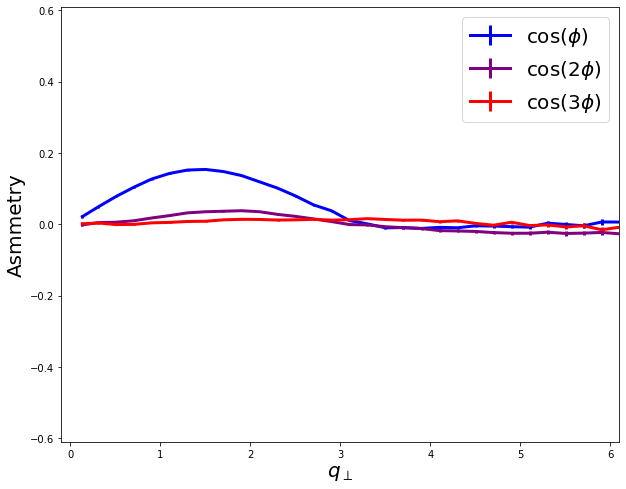

In [35]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(q_perp_avg,of_cosphi,yerr=errors,label="$\cos(\phi)$",color="blue",linewidth=3)
plt.errorbar(q_perp_avg,of_cos2_phi,yerr=errors,label="$\cos(2\phi)$",color="purple",linewidth=3)
plt.errorbar(q_perp_avg,of_cos3_phi,yerr=errors,label="$\cos(3\phi)$",color="red",linewidth=3)
plt.xlim(-0.1,6.1)
plt.ylim(-.61,.61)
plt.legend(fontsize=20)
plt.xlabel("$q_\perp$",fontsize=20)
plt.ylabel("Asmmetry",fontsize=20)
plt.savefig("unfolded_separately.pdf")


Text(0.5, 1.0, 'Rapgap, and Pythia')

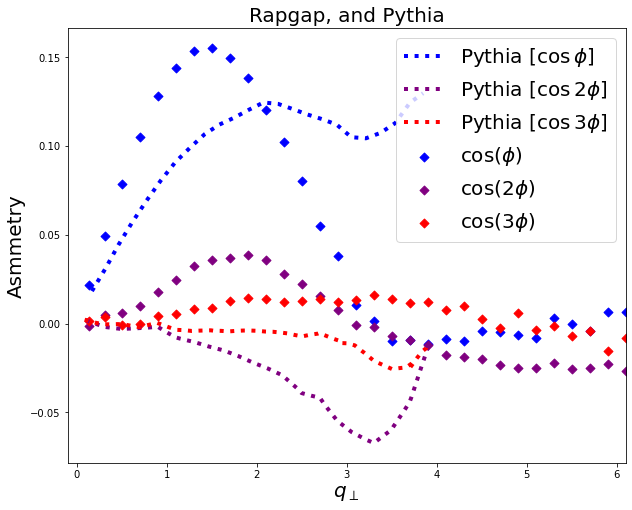

In [18]:
plot_data = True
plot_theory = False
plot_pythia = True

fig = plt.figure(figsize=(10,8))

if (plot_data):
    plt.scatter(q_perp_avg,of_cosphi,label="$\cos(\phi)$",color="blue",s=40,marker="D")
    plt.scatter(q_perp_avg,of_cos2_phi,label="$\cos(2\phi)$",color="purple",s=40,marker="D")
    plt.scatter(q_perp_avg,of_cos3_phi,label="$\cos(3\phi)$",color="red",s=40,marker="D")

if (plot_theory):
    plt.plot(theory['cos1_x'],theory['cos1'],label="Theory [$\cos\phi$]",linewidth=4,linestyle="dashed",color="blue")
    plt.plot(theory['cos2_x'],theory['cos2'],label="Theory [$\cos2\phi$]",linewidth=4,linestyle="dashed",color="purple")
    plt.plot(theory['cos3_x'],theory['cos3'],label="Theory [$\cos3\phi$]",linewidth=4,linestyle="dashdot",color="red")
    
if (plot_pythia):
    plt.plot(pythia['cos1_x'],pythia['cos1'],label="Pythia [$\cos\phi$]",linewidth=4,linestyle="dotted",color="blue")
    plt.plot(pythia['cos2_x'],pythia['cos2'],label="Pythia [$\cos2\phi$]",linewidth=4,linestyle="dotted",color="purple")
    plt.plot(pythia['cos3_x'],pythia['cos3'],label="Pythia [$\cos3\phi$]",linewidth=4,linestyle="dotted",color="red")

plt.xlim(-0.1,6.1)
#plt.ylim(-1.61,0.61)
plt.legend(fontsize=20)
plt.xlabel("$q_\perp$",fontsize=20)
plt.ylabel("Asmmetry",fontsize=20)

string = ""
theory_string = ""
pythia_sttring = ""
if (plot_data):
    if (unfold):
        string = "Unfolded H1, "
    else:
        string = "Rapgap, "

if (plot_theory and plot_pythia):
    string += " Theory, and Pythia"

elif (plot_theory):
    string += "and Theory"

elif (plot_pythia):
    string += "and Pythia"
    
    
    
plt.savefig(string+".pdf")
plt.title(string,fontsize=20)

___

In [38]:
recalc_avg = True

if (recalc_avg and unfold):
    cos_avg  = np.zeros(N_Bins-1)
    cos2_avg = np.zeros(N_Bins-1)
    cos3_avg = np.zeros(N_Bins-1)

    cos_weight_sum = np.zeros(N_Bins-1)
    cos2_weight_sum = np.zeros(N_Bins-1)
    cos3_weight_sum = np.zeros(N_Bins-1)

    for i in range(0,len(asymm_phi)):
#for i in range(0,1000):
    
        if np.isnan(asymm_phi[i]): continue
    
        cosbin = cos_digits[i]
        cos2bin = cos2_digits[i]
        cos3bin = cos3_digits[i]

        cos_avg[cosbin]   += cos_phi[i]*weights[i]
        cos2_avg[cos2bin] += cos2_phi[i]*weights[i]
        cos3_avg[cos3bin] += cos3_phi[i]*weights[i]
    
        cos_weight_sum[cosbin]   += weights[i]
        cos2_weight_sum[cos2bin] += weights[i]
        cos3_weight_sum[cos3bin] += weights[i]
    
    cos_avg = cos_avg/cos_weight_sum
    cos2_avg = cos2_avg/cos2_weight_sum
    cos3_avg = cos3_avg/cos3_weight_sum

    np.save("of_cos1_avg",cos_avg)
    np.save("of_cos2_avg",cos2_avg)
    np.save("of_cos3_avg",cos3_avg)
#plt.hist(asymm_bins,cos_avg)